In [59]:
import torch
from torchvision import datasets

In [60]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from utils import label2one_hot
from generate_data import generate_data, generate_grid_data
from modules import Dropout
from modules import Linear, Sequential
import modules
from modules.losses import LossMSE, LossCrossEntropy
from optimizers import SGD


In [61]:
def convert_to_one_hot_labels(input, target, val=0):
    tmp = input.new(target.size(0), target.max() + 1).fill_(-1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    if val == 0:      
        ret = (tmp+1)/2
    if val == -1:
        ret = tmp
    return ret

def load_data(one_hot_labels = False, normalize = False, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val = 0):

    if data_dir is None:
        """
        data_dir = os.environ.get('PYTORCH_DATA_DIR')
        if data_dir is None:
            data_dir = './data'
        """
        data_dir = './data'
        
    if cifar is not None and cifar:
        print('* Using CIFAR')
        cifar_train_set = datasets.CIFAR10(data_dir + '/cifar10/', train = True, download = True)
        cifar_test_set = datasets.CIFAR10(data_dir + '/cifar10/', train = False, download = True)

        train_input = torch.from_numpy(cifar_train_set.train_data)
        # Dirty hack to handle the change between torchvision 1.0.6 and 1.0.8
        if train_input.size(3) == 3:
            train_input = train_input.transpose(3, 1).transpose(2, 3).float()
        else:
            train_input = train_input.float()
        train_target = torch.LongTensor(cifar_train_set.train_labels)

        test_input = torch.from_numpy(cifar_test_set.test_data).float()
        # Dirty hack to handle the change between torchvision 1.0.6 and 1.0.8
        if test_input.size(3) == 3:
            test_input = test_input.transpose(3, 1).transpose(2, 3).float()
        else:
            test_input = test_input.float()
        test_target = torch.LongTensor(cifar_test_set.test_labels)

    else:
        print('* Using MNIST')
        mnist_train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
        mnist_test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)

        train_input = mnist_train_set.train_data.view(-1, 1, 28, 28).float()
        train_target = mnist_train_set.train_labels
        test_input = mnist_test_set.test_data.view(-1, 1, 28, 28).float()
        test_target = mnist_test_set.test_labels

    if flatten:
        train_input = train_input.clone().view(train_input.size(0), -1)
        test_input = test_input.clone().view(test_input.size(0), -1)

    if full:
        if tiny:
            raise ValueError('Cannot have both --full and --tiny')
    else:
        if tiny:
            print('** Reduce the data-set to the tiny setup')
            train_input = train_input.narrow(0, 0, 500)
            train_target = train_target.narrow(0, 0, 500)
            test_input = test_input.narrow(0, 0, 100)
            test_target = test_target.narrow(0, 0, 100)
        else:
            print('** Reduce the data-set (use --full for the full thing)')
            train_input = train_input.narrow(0, 0, 1000)
            train_target = train_target.narrow(0, 0, 1000)
            test_input = test_input.narrow(0, 0, 1000)
            test_target = test_target.narrow(0, 0, 1000)

    print('** Use {:d} train and {:d} test samples'.format(train_input.size(0), test_input.size(0)))

    if one_hot_labels:
        train_target = convert_to_one_hot_labels(train_input, train_target, val=val)
        test_target = convert_to_one_hot_labels(test_input, test_target, val=val)

    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)

    return train_input, train_target, test_input, test_target


In [62]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val=0)
train_input_mse, train_target_mse, test_input_mse, test_target_mse = load_data(one_hot_labels = True, normalize = True, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val=-1)

* Using MNIST
** Use 60000 train and 10000 test samples
* Using MNIST
** Use 60000 train and 10000 test samples


In [63]:
train_input.size()

torch.Size([60000, 784])

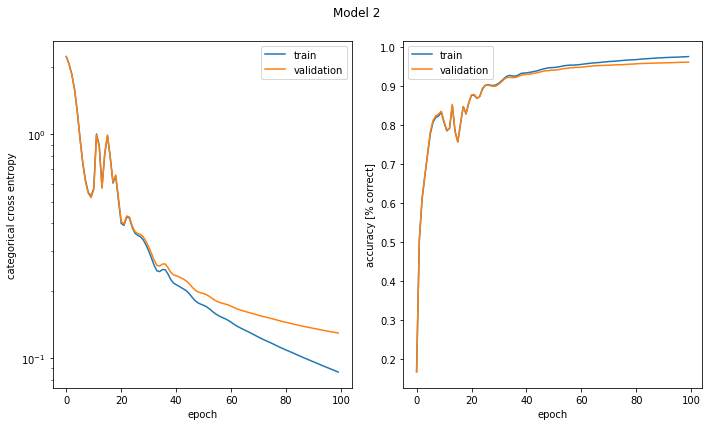

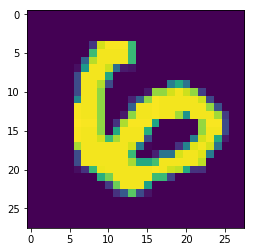

In [64]:
fig = plt.figure()
plt.imshow(train_input[9000,:].view(28,28))
plt.show()

In [65]:
train_target

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  1.,  0.]])

In [66]:
train_target_mse

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1.,  1., -1.]])

In [40]:
def default_net_1(x_all, y_all, num_of_neurons=(2, 25, 2), activation='relu', lr=0.1, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=100, val_split=0.2, verbose=0):
    ce = LossCrossEntropy()

    model = Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation=activation))
    model.add(Dropout(prob=p_dropout))

    model.add(Linear(out=num_of_neurons[2], activation='softmax'))

    model.loss = ce
    sgd = SGD(lr, momentum_coef, weight_decay=weight_decay)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=val_split, verbose=verbose)

    return model, report

def default_net_2(x_all, y_all, num_of_neurons=(2, 25, 25, 2), activation='relu', lr=0.1, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=100, val_split=0.2, verbose=0):
    ce = LossCrossEntropy()

    model = Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation=activation))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[2], activation=activation))
    model.add(Dropout(prob=p_dropout))

    model.add(Linear(out=num_of_neurons[3], activation='softmax'))

    model.loss = ce
    sgd = SGD(lr, momentum_coef, weight_decay=weight_decay)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=val_split, verbose=verbose)

    return model, report


def default_net_3(x_all, y_all, num_of_neurons=(2, 25, 25, 25, 2), activation='relu', lr=0.1, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=100, val_split=0.2, verbose=0):
    ce = LossCrossEntropy()

    model = Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation=activation))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[2], activation=activation))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[3], activation=activation))
    model.add(Dropout(prob=p_dropout))
    
    model.add(Linear(out=num_of_neurons[4], activation='softmax'))

    model.loss = ce
    sgd = SGD(lr, momentum_coef, weight_decay=weight_decay)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=val_split, verbose=verbose)

    return model, report

def default_net_4(x_all, y_all, num_of_neurons=(2, 25, 25, 25, 2), activation='relu', lr=0.001, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=100, val_split=0.2, verbose=0):
    mse = LossMSE()
    
    model = modules.Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation='relu'))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[2], activation='relu'))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[3], activation='relu'))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[4], activation='relu'))

    model.loss = mse
    sgd = SGD(lr, momentum_coef, weight_decay=0.0)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=val_split, verbose=0)

    return model, report

In [41]:
def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot(costs, accs, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(costs, label = "test")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(accs, label = "test")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_v2(train_report, title=""):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(train_report["train_loss"], label = "train")
    ax1.plot(train_report["val_loss"], label = "validation")
    ax2.plot(train_report["train_acc"], label = "train")
    ax2.plot(train_report["val_acc"], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [53]:
print(train_input.shape, " -- ", train_target.shape)

torch.Size([60000, 784])  --  torch.Size([60000, 10])


In [42]:
model1, train1 = default_net_1(train_input, train_target, num_of_neurons=(784, 500, 10), activation='relu', lr=0.1, momentum_coef=0.9, weight_decay=0.2, p_dropout=0.0, num_of_epochs=100, val_split=0.5, verbose=0)
test1 = model1.evaluate(test_input, test_target, return_pred=True)

torch.Size([60000, 784])  --  torch.Size([60000, 10])
Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Dropout 
Added Module Name: 3_Linear 
Added Module Name: 4_Softmax 
x_train.shape: torch.Size([30000, 784]) -- y_train.shape: torch.Size([30000, 10])
x_val.shape: torch.Size([30000, 784]) -- y_val.shape: torch.Size([30000, 10])


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.8459798097610474
key: train_acc -- value: 0.5518333315849304
key: val_loss -- value: 1.847193956375122
key: val_acc -- value: 0.5493999719619751


  1%|▊                                                                                 | 1/100 [00:01<03:10,  1.93s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.3053184747695923
key: train_acc -- value: 0.6920333504676819
key: val_loss -- value: 1.3082276582717896
key: val_acc -- value: 0.6959333419799805


  2%|█▋                                                                                | 2/100 [00:03<03:10,  1.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.8658832311630249
key: train_acc -- value: 0.7905333042144775
key: val_loss -- value: 0.8667533993721008
key: val_acc -- value: 0.7936999797821045


  3%|██▍                                                                               | 3/100 [00:05<03:11,  1.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.660820722579956
key: train_acc -- value: 0.819100022315979
key: val_loss -- value: 0.6587761044502258
key: val_acc -- value: 0.8215333223342896


  4%|███▎                                                                              | 4/100 [00:07<03:09,  1.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5417323708534241
key: train_acc -- value: 0.8388333320617676
key: val_loss -- value: 0.537997305393219
key: val_acc -- value: 0.8404666781425476


  5%|████                                                                              | 5/100 [00:09<03:06,  1.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.49889862537384033
key: train_acc -- value: 0.8403333425521851
key: val_loss -- value: 0.49355489015579224
key: val_acc -- value: 0.8451333045959473


  6%|████▉                                                                             | 6/100 [00:11<03:03,  1.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.46182939410209656
key: train_acc -- value: 0.8597333431243896
key: val_loss -- value: 0.45501288771629333
key: val_acc -- value: 0.8628666400909424


  7%|█████▋                                                                            | 7/100 [00:13<03:00,  1.94s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4578413963317871
key: train_acc -- value: 0.8691666722297668
key: val_loss -- value: 0.45193400979042053
key: val_acc -- value: 0.8712999820709229


  8%|██████▌                                                                           | 8/100 [00:15<02:57,  1.93s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4434974491596222
key: train_acc -- value: 0.8756666779518127
key: val_loss -- value: 0.43848881125450134
key: val_acc -- value: 0.8783666491508484


  9%|███████▍                                                                          | 9/100 [00:17<02:54,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.43488115072250366
key: train_acc -- value: 0.8798666596412659
key: val_loss -- value: 0.4316897392272949
key: val_acc -- value: 0.8813333511352539


 10%|████████                                                                         | 10/100 [00:19<02:52,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4308067560195923
key: train_acc -- value: 0.8841000199317932
key: val_loss -- value: 0.43081846833229065
key: val_acc -- value: 0.8846666812896729


 11%|████████▉                                                                        | 11/100 [00:21<02:50,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.42383870482444763
key: train_acc -- value: 0.8893333077430725
key: val_loss -- value: 0.4277980923652649
key: val_acc -- value: 0.8887333273887634


 12%|█████████▋                                                                       | 12/100 [00:23<02:49,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.418027400970459
key: train_acc -- value: 0.8914999961853027
key: val_loss -- value: 0.42450061440467834
key: val_acc -- value: 0.8899000287055969


 13%|██████████▌                                                                      | 13/100 [00:24<02:46,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3985465168952942
key: train_acc -- value: 0.8974000215530396
key: val_loss -- value: 0.4056898355484009
key: val_acc -- value: 0.8945000171661377


 14%|███████████▎                                                                     | 14/100 [00:26<02:45,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3919314444065094
key: train_acc -- value: 0.8985999822616577
key: val_loss -- value: 0.40038493275642395
key: val_acc -- value: 0.8957666754722595


 15%|████████████▏                                                                    | 15/100 [00:28<02:42,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.37408584356307983
key: train_acc -- value: 0.9032333493232727
key: val_loss -- value: 0.38529857993125916
key: val_acc -- value: 0.9002333283424377


 16%|████████████▉                                                                    | 16/100 [00:30<02:41,  1.93s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.36201366782188416
key: train_acc -- value: 0.9053999781608582
key: val_loss -- value: 0.37674909830093384
key: val_acc -- value: 0.9014666676521301


 17%|█████████████▊                                                                   | 17/100 [00:32<02:39,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3445375859737396
key: train_acc -- value: 0.9090666770935059
key: val_loss -- value: 0.3621565103530884
key: val_acc -- value: 0.904366672039032


 18%|██████████████▌                                                                  | 18/100 [00:34<02:37,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3306010067462921
key: train_acc -- value: 0.9118000268936157
key: val_loss -- value: 0.3508502244949341
key: val_acc -- value: 0.9072333574295044


 19%|███████████████▍                                                                 | 19/100 [00:36<02:36,  1.93s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3181406855583191
key: train_acc -- value: 0.9126666784286499
key: val_loss -- value: 0.341025173664093
key: val_acc -- value: 0.9083666801452637


 20%|████████████████▏                                                                | 20/100 [00:38<02:35,  1.94s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3029564321041107
key: train_acc -- value: 0.9154666662216187
key: val_loss -- value: 0.32801398634910583
key: val_acc -- value: 0.9097999930381775


 21%|█████████████████                                                                | 21/100 [00:40<02:34,  1.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2929084002971649
key: train_acc -- value: 0.9179333448410034
key: val_loss -- value: 0.3195166289806366
key: val_acc -- value: 0.9109333157539368


 22%|█████████████████▊                                                               | 22/100 [00:43<02:32,  1.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2780650854110718
key: train_acc -- value: 0.9215333461761475
key: val_loss -- value: 0.30594995617866516
key: val_acc -- value: 0.9137333035469055


 23%|██████████████████▋                                                              | 23/100 [00:45<02:31,  1.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2707369327545166
key: train_acc -- value: 0.923633337020874
key: val_loss -- value: 0.3001905083656311
key: val_acc -- value: 0.9159333109855652


 24%|███████████████████▍                                                             | 24/100 [00:47<02:29,  1.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2589842975139618
key: train_acc -- value: 0.9258666634559631
key: val_loss -- value: 0.28949007391929626
key: val_acc -- value: 0.9178333282470703


 25%|████████████████████▎                                                            | 25/100 [00:49<02:28,  1.98s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.25119754672050476
key: train_acc -- value: 0.9272333383560181
key: val_loss -- value: 0.28243887424468994
key: val_acc -- value: 0.9196666479110718


 26%|█████████████████████                                                            | 26/100 [00:51<02:26,  1.98s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.24170233309268951
key: train_acc -- value: 0.930233359336853
key: val_loss -- value: 0.2736952602863312
key: val_acc -- value: 0.9215333461761475


 27%|█████████████████████▊                                                           | 27/100 [00:53<02:25,  1.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.23540061712265015
key: train_acc -- value: 0.9321333169937134
key: val_loss -- value: 0.2680753469467163
key: val_acc -- value: 0.9225333333015442


 28%|██████████████████████▋                                                          | 28/100 [00:55<02:23,  1.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.22761064767837524
key: train_acc -- value: 0.9337666630744934
key: val_loss -- value: 0.2601814568042755
key: val_acc -- value: 0.9243666529655457


 29%|███████████████████████▍                                                         | 29/100 [00:58<02:22,  2.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2213517278432846
key: train_acc -- value: 0.9360666871070862
key: val_loss -- value: 0.2532408833503723
key: val_acc -- value: 0.9267333149909973


 30%|████████████████████████▎                                                        | 30/100 [01:00<02:20,  2.01s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.21611618995666504
key: train_acc -- value: 0.9377999901771545
key: val_loss -- value: 0.2473486065864563
key: val_acc -- value: 0.9290000200271606


 31%|█████████████████████████                                                        | 31/100 [01:02<02:18,  2.01s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.21013012528419495
key: train_acc -- value: 0.9390000104904175
key: val_loss -- value: 0.24117666482925415
key: val_acc -- value: 0.9306333065032959


 32%|█████████████████████████▉                                                       | 32/100 [01:04<02:16,  2.01s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2058980017900467
key: train_acc -- value: 0.9402333498001099
key: val_loss -- value: 0.2373291403055191
key: val_acc -- value: 0.9318000078201294


 33%|██████████████████████████▋                                                      | 33/100 [01:06<02:14,  2.01s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.20056039094924927
key: train_acc -- value: 0.9416999816894531
key: val_loss -- value: 0.23246151208877563
key: val_acc -- value: 0.9329333305358887


 34%|███████████████████████████▌                                                     | 34/100 [01:08<02:13,  2.02s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1965884417295456
key: train_acc -- value: 0.9434000253677368
key: val_loss -- value: 0.2284780740737915
key: val_acc -- value: 0.9338666796684265


 35%|████████████████████████████▎                                                    | 35/100 [01:10<02:11,  2.02s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.19156941771507263
key: train_acc -- value: 0.9451000094413757
key: val_loss -- value: 0.2227018177509308
key: val_acc -- value: 0.9356666803359985


 36%|█████████████████████████████▏                                                   | 36/100 [01:12<02:09,  2.02s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.187851682305336
key: train_acc -- value: 0.946233332157135
key: val_loss -- value: 0.21836380660533905
key: val_acc -- value: 0.9372333288192749


 37%|█████████████████████████████▉                                                   | 37/100 [01:14<02:07,  2.02s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1834181845188141
key: train_acc -- value: 0.9476000070571899
key: val_loss -- value: 0.21416085958480835
key: val_acc -- value: 0.9381333589553833


 38%|██████████████████████████████▊                                                  | 38/100 [01:17<02:05,  2.03s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.17924430966377258
key: train_acc -- value: 0.9484999775886536
key: val_loss -- value: 0.21080054342746735
key: val_acc -- value: 0.9387000203132629


 39%|███████████████████████████████▌                                                 | 39/100 [01:19<02:04,  2.03s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1758001446723938
key: train_acc -- value: 0.9492999911308289
key: val_loss -- value: 0.20795337855815887
key: val_acc -- value: 0.9394999742507935


 40%|████████████████████████████████▍                                                | 40/100 [01:21<02:02,  2.04s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.17191100120544434
key: train_acc -- value: 0.9501333236694336
key: val_loss -- value: 0.2040790468454361
key: val_acc -- value: 0.941433310508728


 41%|█████████████████████████████████▏                                               | 41/100 [01:23<02:00,  2.04s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.16865065693855286
key: train_acc -- value: 0.9512333273887634
key: val_loss -- value: 0.20067082345485687
key: val_acc -- value: 0.9423333406448364


 42%|██████████████████████████████████                                               | 42/100 [01:25<01:58,  2.04s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.16530418395996094
key: train_acc -- value: 0.9520999789237976
key: val_loss -- value: 0.19740049540996552
key: val_acc -- value: 0.9434000253677368


 43%|██████████████████████████████████▊                                              | 43/100 [01:28<01:56,  2.05s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.16216443479061127
key: train_acc -- value: 0.9531999826431274
key: val_loss -- value: 0.19453991949558258
key: val_acc -- value: 0.9440666437149048


 44%|███████████████████████████████████▋                                             | 44/100 [01:30<01:54,  2.05s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.15936025977134705
key: train_acc -- value: 0.9541333317756653
key: val_loss -- value: 0.19213376939296722
key: val_acc -- value: 0.9442999958992004


 45%|████████████████████████████████████▍                                            | 45/100 [01:32<01:53,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1563200056552887
key: train_acc -- value: 0.9552333354949951
key: val_loss -- value: 0.18955211341381073
key: val_acc -- value: 0.9453666806221008


 46%|█████████████████████████████████████▎                                           | 46/100 [01:34<01:51,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.15365706384181976
key: train_acc -- value: 0.9563666582107544
key: val_loss -- value: 0.18738900125026703
key: val_acc -- value: 0.9460333585739136


 47%|██████████████████████████████████████                                           | 47/100 [01:36<01:49,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.151036337018013
key: train_acc -- value: 0.9571333527565002
key: val_loss -- value: 0.1851990818977356
key: val_acc -- value: 0.9466999769210815


 48%|██████████████████████████████████████▉                                          | 48/100 [01:38<01:47,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.14840224385261536
key: train_acc -- value: 0.9571999907493591
key: val_loss -- value: 0.18288250267505646
key: val_acc -- value: 0.9476000070571899


 49%|███████████████████████████████████████▋                                         | 49/100 [01:40<01:45,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.14610494673252106
key: train_acc -- value: 0.9581000208854675
key: val_loss -- value: 0.18090376257896423
key: val_acc -- value: 0.9480999708175659


 50%|████████████████████████████████████████▌                                        | 50/100 [01:43<01:43,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1436253935098648
key: train_acc -- value: 0.9589666724205017
key: val_loss -- value: 0.17883266508579254
key: val_acc -- value: 0.9487666487693787


 51%|█████████████████████████████████████████▎                                       | 51/100 [01:45<01:41,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.14132149517536163
key: train_acc -- value: 0.9598666429519653
key: val_loss -- value: 0.17704316973686218
key: val_acc -- value: 0.94923335313797


 52%|██████████████████████████████████████████                                       | 52/100 [01:47<01:39,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13919615745544434
key: train_acc -- value: 0.9603999853134155
key: val_loss -- value: 0.1754501760005951
key: val_acc -- value: 0.9498000144958496


 53%|██████████████████████████████████████████▉                                      | 53/100 [01:49<01:37,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1369735300540924
key: train_acc -- value: 0.9609666466712952
key: val_loss -- value: 0.17371217906475067
key: val_acc -- value: 0.9499333500862122


 54%|███████████████████████████████████████████▋                                     | 54/100 [01:51<01:35,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13490809500217438
key: train_acc -- value: 0.9614999890327454
key: val_loss -- value: 0.17208944261074066
key: val_acc -- value: 0.9502333402633667


 55%|████████████████████████████████████████████▌                                    | 55/100 [01:53<01:33,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13287703692913055
key: train_acc -- value: 0.962066650390625
key: val_loss -- value: 0.1704503297805786
key: val_acc -- value: 0.9507333040237427


 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:56<01:31,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13088488578796387
key: train_acc -- value: 0.9630333185195923
key: val_loss -- value: 0.16879428923130035
key: val_acc -- value: 0.951033353805542


 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:58<01:29,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12901952862739563
key: train_acc -- value: 0.9632333517074585
key: val_loss -- value: 0.1672506183385849
key: val_acc -- value: 0.9514999985694885


 58%|██████████████████████████████████████████████▉                                  | 58/100 [02:00<01:27,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1271263211965561
key: train_acc -- value: 0.9638000130653381
key: val_loss -- value: 0.16569428145885468
key: val_acc -- value: 0.9521333575248718


 59%|███████████████████████████████████████████████▊                                 | 59/100 [02:02<01:24,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12529748678207397
key: train_acc -- value: 0.9645666480064392
key: val_loss -- value: 0.16422098875045776
key: val_acc -- value: 0.9522333145141602


 60%|████████████████████████████████████████████████▌                                | 60/100 [02:04<01:22,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1235877051949501
key: train_acc -- value: 0.9649666547775269
key: val_loss -- value: 0.16282527148723602
key: val_acc -- value: 0.9524999856948853


 61%|█████████████████████████████████████████████████▍                               | 61/100 [02:06<01:20,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12186428904533386
key: train_acc -- value: 0.9652000069618225
key: val_loss -- value: 0.16132918000221252
key: val_acc -- value: 0.9528666734695435


 62%|██████████████████████████████████████████████████▏                              | 62/100 [02:08<01:18,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12019571661949158
key: train_acc -- value: 0.9657999873161316
key: val_loss -- value: 0.15983887016773224
key: val_acc -- value: 0.9533666372299194


 63%|███████████████████████████████████████████████████                              | 63/100 [02:10<01:16,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11860204488039017
key: train_acc -- value: 0.9660999774932861
key: val_loss -- value: 0.15845626592636108
key: val_acc -- value: 0.9539666771888733


 64%|███████████████████████████████████████████████████▊                             | 64/100 [02:12<01:14,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11701688170433044
key: train_acc -- value: 0.9666333198547363
key: val_loss -- value: 0.15716204047203064
key: val_acc -- value: 0.9542333483695984


 65%|████████████████████████████████████████████████████▋                            | 65/100 [02:14<01:12,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11548005044460297
key: train_acc -- value: 0.9670666456222534
key: val_loss -- value: 0.15596599876880646
key: val_acc -- value: 0.9545666575431824


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [02:16<01:10,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11398330330848694
key: train_acc -- value: 0.9677333235740662
key: val_loss -- value: 0.15477485954761505
key: val_acc -- value: 0.9548666477203369


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [02:18<01:08,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11249377578496933
key: train_acc -- value: 0.9681333303451538
key: val_loss -- value: 0.153513103723526
key: val_acc -- value: 0.9552333354949951


 68%|███████████████████████████████████████████████████████                          | 68/100 [02:20<01:06,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11105155944824219
key: train_acc -- value: 0.9686999917030334
key: val_loss -- value: 0.1522604525089264
key: val_acc -- value: 0.9553999900817871


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [02:22<01:04,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10964782536029816
key: train_acc -- value: 0.9692000150680542
key: val_loss -- value: 0.15107637643814087
key: val_acc -- value: 0.9558333158493042


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [02:25<01:02,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10825490206480026
key: train_acc -- value: 0.9694333076477051
key: val_loss -- value: 0.149969220161438
key: val_acc -- value: 0.9560999870300293


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [02:27<01:00,  2.08s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10690709948539734
key: train_acc -- value: 0.9700333476066589
key: val_loss -- value: 0.14895077049732208
key: val_acc -- value: 0.956333339214325


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [02:29<00:58,  2.08s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10559209436178207
key: train_acc -- value: 0.970466673374176
key: val_loss -- value: 0.14795321226119995
key: val_acc -- value: 0.9565666913986206


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [02:31<00:56,  2.08s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10428863018751144
key: train_acc -- value: 0.970966637134552
key: val_loss -- value: 0.14692845940589905
key: val_acc -- value: 0.9571333527565002


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [02:34<00:54,  2.08s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10302410274744034
key: train_acc -- value: 0.970966637134552
key: val_loss -- value: 0.14591361582279205
key: val_acc -- value: 0.9573333263397217


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [02:36<00:52,  2.08s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1017833799123764
key: train_acc -- value: 0.9713333249092102
key: val_loss -- value: 0.14492642879486084
key: val_acc -- value: 0.9575666785240173


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [02:38<00:50,  2.08s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10055685043334961
key: train_acc -- value: 0.9718000292778015
key: val_loss -- value: 0.1439691036939621
key: val_acc -- value: 0.9578666687011719


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [02:40<00:47,  2.08s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09936413913965225
key: train_acc -- value: 0.972266674041748
key: val_loss -- value: 0.14305131137371063
key: val_acc -- value: 0.9580666422843933


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [02:42<00:45,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09819348901510239
key: train_acc -- value: 0.972599983215332
key: val_loss -- value: 0.14214099943637848
key: val_acc -- value: 0.9581666588783264


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [02:44<00:43,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09703951328992844
key: train_acc -- value: 0.972766637802124
key: val_loss -- value: 0.1412360519170761
key: val_acc -- value: 0.9583333134651184


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [02:46<00:41,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.095912866294384
key: train_acc -- value: 0.9732000231742859
key: val_loss -- value: 0.14036715030670166
key: val_acc -- value: 0.9586666822433472


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [02:49<00:39,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09480767697095871
key: train_acc -- value: 0.9733333587646484
key: val_loss -- value: 0.13954371213912964
key: val_acc -- value: 0.9589333534240723


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [02:51<00:37,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09371905028820038
key: train_acc -- value: 0.9736999869346619
key: val_loss -- value: 0.13875341415405273
key: val_acc -- value: 0.9592000246047974


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [02:53<00:35,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09265347570180893
key: train_acc -- value: 0.9742666482925415
key: val_loss -- value: 0.13797621428966522
key: val_acc -- value: 0.9593666791915894


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [02:55<00:33,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.091607965528965
key: train_acc -- value: 0.9746333360671997
key: val_loss -- value: 0.1371934413909912
key: val_acc -- value: 0.9595999717712402


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [02:57<00:31,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.0905778780579567
key: train_acc -- value: 0.9749666452407837
key: val_loss -- value: 0.13640591502189636
key: val_acc -- value: 0.9599000215530396


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [02:59<00:29,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08956676721572876
key: train_acc -- value: 0.9753333330154419
key: val_loss -- value: 0.13563968241214752
key: val_acc -- value: 0.9599999785423279


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [03:01<00:27,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08857446908950806
key: train_acc -- value: 0.9756666421890259
key: val_loss -- value: 0.13490718603134155
key: val_acc -- value: 0.9603666663169861


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [03:03<00:25,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08759620785713196
key: train_acc -- value: 0.9761333465576172
key: val_loss -- value: 0.13420313596725464
key: val_acc -- value: 0.9606666564941406


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [03:06<00:23,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08663418143987656
key: train_acc -- value: 0.9762333035469055
key: val_loss -- value: 0.13351711630821228
key: val_acc -- value: 0.9606999754905701


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [03:08<00:20,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08568938076496124
key: train_acc -- value: 0.9764999747276306
key: val_loss -- value: 0.13284333050251007
key: val_acc -- value: 0.9607333540916443


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [03:10<00:18,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08475853502750397
key: train_acc -- value: 0.9767000079154968
key: val_loss -- value: 0.13217909634113312
key: val_acc -- value: 0.9609000086784363


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [03:12<00:16,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08384271711111069
key: train_acc -- value: 0.9769666790962219
key: val_loss -- value: 0.13152863085269928
key: val_acc -- value: 0.9611666798591614


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [03:14<00:14,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08294165879487991
key: train_acc -- value: 0.9771000146865845
key: val_loss -- value: 0.13088855147361755
key: val_acc -- value: 0.9614333510398865


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [03:16<00:12,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08205458521842957
key: train_acc -- value: 0.9773666858673096
key: val_loss -- value: 0.1302545666694641
key: val_acc -- value: 0.9617999792098999


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [03:18<00:10,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08118137717247009
key: train_acc -- value: 0.9776333570480347
key: val_loss -- value: 0.1296270340681076
key: val_acc -- value: 0.9619666934013367


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [03:20<00:08,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08032336086034775
key: train_acc -- value: 0.9780666828155518
key: val_loss -- value: 0.12901204824447632
key: val_acc -- value: 0.962066650390625


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [03:23<00:06,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.07947777956724167
key: train_acc -- value: 0.9782000184059143
key: val_loss -- value: 0.12841449677944183
key: val_acc -- value: 0.962233304977417


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [03:25<00:04,  2.10s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.0786447525024414
key: train_acc -- value: 0.9783333539962769
key: val_loss -- value: 0.12783664464950562
key: val_acc -- value: 0.9624333381652832


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [03:27<00:02,  2.09s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.0778244361281395
key: train_acc -- value: 0.9786333441734314
key: val_loss -- value: 0.12727366387844086
key: val_acc -- value: 0.9624666571617126


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.09s/it]


torch.Size([10000, 10])  --  torch.Size([10000, 10])


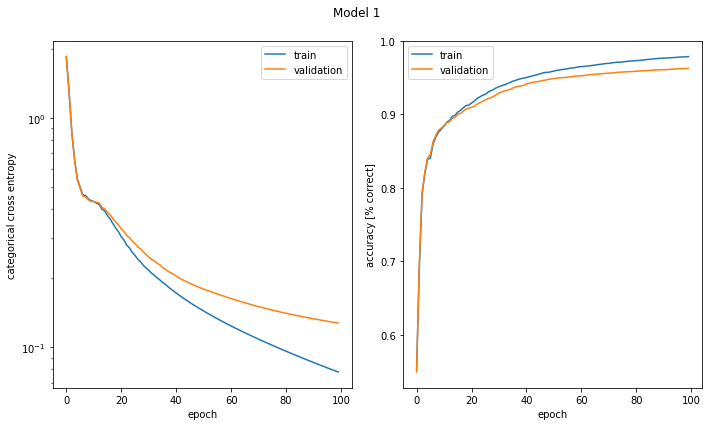

In [43]:
plot_v2(train1, title="Model 1")

In [45]:
test1

(tensor(0.9645), 0.11656615883111954, tensor([ 7,  2,  1,  ...,  4,  5,  6]))

In [46]:
model2, train2 = default_net_2(train_input, train_target, num_of_neurons=(784, 500, 200, 10), activation='relu', lr=0.1, momentum_coef=0.9, weight_decay=0.2, p_dropout=0.0, num_of_epochs=100, val_split=0.5, verbose=0)
test2 = model2.evaluate(test_input, test_target, return_pred=True)

Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Dropout 
Added Module Name: 3_Linear 
Added Module Name: 4_ReLU 
Added Module Name: 5_Dropout 
Added Module Name: 6_Linear 
Added Module Name: 7_Softmax 
x_train.shape: torch.Size([30000, 784]) -- y_train.shape: torch.Size([30000, 10])
x_val.shape: torch.Size([30000, 784]) -- y_val.shape: torch.Size([30000, 10])


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 2.2313287258148193
key: train_acc -- value: 0.1685333400964737
key: val_loss -- value: 2.230912685394287
key: val_acc -- value: 0.1674666702747345


  1%|▊                                                                                 | 1/100 [00:02<04:25,  2.68s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 2.067253828048706
key: train_acc -- value: 0.5042333602905273
key: val_loss -- value: 2.065760850906372
key: val_acc -- value: 0.5057666897773743


  2%|█▋                                                                                | 2/100 [00:05<04:17,  2.63s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.86066472530365
key: train_acc -- value: 0.61080002784729
key: val_loss -- value: 1.8578664064407349
key: val_acc -- value: 0.6120333075523376


  3%|██▍                                                                               | 3/100 [00:07<04:11,  2.59s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.592950701713562
key: train_acc -- value: 0.6687333583831787
key: val_loss -- value: 1.5887540578842163
key: val_acc -- value: 0.6699333190917969


  4%|███▎                                                                              | 4/100 [00:10<04:08,  2.59s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.2700260877609253
key: train_acc -- value: 0.7248666882514954
key: val_loss -- value: 1.264357328414917
key: val_acc -- value: 0.7263666391372681


  5%|████                                                                              | 5/100 [00:12<04:05,  2.59s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.9638966917991638
key: train_acc -- value: 0.7774333357810974
key: val_loss -- value: 0.9561605453491211
key: val_acc -- value: 0.7833666801452637


  6%|████▉                                                                             | 6/100 [00:15<04:02,  2.58s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.7493395209312439
key: train_acc -- value: 0.8077999949455261
key: val_loss -- value: 0.740321934223175
key: val_acc -- value: 0.8120999932289124


  7%|█████▋                                                                            | 7/100 [00:17<03:57,  2.56s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.6226859092712402
key: train_acc -- value: 0.8195000290870667
key: val_loss -- value: 0.6131640672683716
key: val_acc -- value: 0.8239333629608154


  8%|██████▌                                                                           | 8/100 [00:20<03:55,  2.56s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.551338791847229
key: train_acc -- value: 0.8232333064079285
key: val_loss -- value: 0.5456318259239197
key: val_acc -- value: 0.8282666802406311


  9%|███████▍                                                                          | 9/100 [00:23<03:53,  2.57s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5289865136146545
key: train_acc -- value: 0.833133339881897
key: val_loss -- value: 0.5217936038970947
key: val_acc -- value: 0.8355000019073486


 10%|████████                                                                         | 10/100 [00:25<03:50,  2.56s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5737429857254028
key: train_acc -- value: 0.8062666654586792
key: val_loss -- value: 0.5659000873565674
key: val_acc -- value: 0.8099333047866821


 11%|████████▉                                                                        | 11/100 [00:28<03:48,  2.56s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.00543212890625
key: train_acc -- value: 0.7851999998092651
key: val_loss -- value: 0.9951137900352478
key: val_acc -- value: 0.7872999906539917


 12%|█████████▋                                                                       | 12/100 [00:30<03:44,  2.55s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.8943419456481934
key: train_acc -- value: 0.791533350944519
key: val_loss -- value: 0.8807002902030945
key: val_acc -- value: 0.7918333411216736


 13%|██████████▌                                                                      | 13/100 [00:32<03:40,  2.54s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.581473171710968
key: train_acc -- value: 0.850433349609375
key: val_loss -- value: 0.5742735862731934
key: val_acc -- value: 0.8531333208084106


 14%|███████████▎                                                                     | 14/100 [00:35<03:37,  2.53s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.8186296224594116
key: train_acc -- value: 0.7842333316802979
key: val_loss -- value: 0.822333812713623
key: val_acc -- value: 0.7846333384513855


 15%|████████████▏                                                                    | 15/100 [00:38<03:35,  2.54s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.9881188869476318
key: train_acc -- value: 0.7573666572570801
key: val_loss -- value: 0.994802713394165
key: val_acc -- value: 0.7565000057220459


 16%|████████████▉                                                                    | 16/100 [00:40<03:33,  2.54s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.7917078137397766
key: train_acc -- value: 0.8037333488464355
key: val_loss -- value: 0.7883415818214417
key: val_acc -- value: 0.8045666813850403


 17%|█████████████▊                                                                   | 17/100 [00:43<03:30,  2.54s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.606428325176239
key: train_acc -- value: 0.8474000096321106
key: val_loss -- value: 0.6120988130569458
key: val_acc -- value: 0.8468999862670898


 18%|██████████████▌                                                                  | 18/100 [00:45<03:29,  2.55s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.6517236828804016
key: train_acc -- value: 0.8283666372299194
key: val_loss -- value: 0.6590279340744019
key: val_acc -- value: 0.8295000195503235


 19%|███████████████▍                                                                 | 19/100 [00:48<03:27,  2.57s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5074608325958252
key: train_acc -- value: 0.8568000197410583
key: val_loss -- value: 0.5192280411720276
key: val_acc -- value: 0.8570666909217834


 20%|████████████████▏                                                                | 20/100 [00:51<03:26,  2.58s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.40024521946907043
key: train_acc -- value: 0.8770333528518677
key: val_loss -- value: 0.40831318497657776
key: val_acc -- value: 0.8772333264350891


 21%|█████████████████                                                                | 21/100 [00:54<03:24,  2.59s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3921004831790924
key: train_acc -- value: 0.8759666681289673
key: val_loss -- value: 0.39782994985580444
key: val_acc -- value: 0.8784000277519226


 22%|█████████████████▊                                                               | 22/100 [00:57<03:22,  2.60s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4277815818786621
key: train_acc -- value: 0.8683000206947327
key: val_loss -- value: 0.43208011984825134
key: val_acc -- value: 0.8687333464622498


 23%|██████████████████▋                                                              | 23/100 [01:00<03:20,  2.61s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4228748381137848
key: train_acc -- value: 0.8734999895095825
key: val_loss -- value: 0.42747190594673157
key: val_acc -- value: 0.8730666637420654


 24%|███████████████████▍                                                             | 24/100 [01:02<03:19,  2.62s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.38445693254470825
key: train_acc -- value: 0.8936333060264587
key: val_loss -- value: 0.3899141550064087
key: val_acc -- value: 0.8911333084106445


 25%|████████████████████▎                                                            | 25/100 [01:05<03:16,  2.62s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3620007634162903
key: train_acc -- value: 0.9019666910171509
key: val_loss -- value: 0.36795443296432495
key: val_acc -- value: 0.9012666940689087


 26%|█████████████████████                                                            | 26/100 [01:08<03:14,  2.63s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3539033532142639
key: train_acc -- value: 0.9033666849136353
key: val_loss -- value: 0.36077287793159485
key: val_acc -- value: 0.9023333191871643


 27%|█████████████████████▊                                                           | 27/100 [01:11<03:12,  2.64s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3488885760307312
key: train_acc -- value: 0.9020333290100098
key: val_loss -- value: 0.35736820101737976
key: val_acc -- value: 0.9005333185195923


 28%|██████████████████████▋                                                          | 28/100 [01:14<03:10,  2.65s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3380626440048218
key: train_acc -- value: 0.9011333584785461
key: val_loss -- value: 0.3484440743923187
key: val_acc -- value: 0.8991333246231079


 29%|███████████████████████▍                                                         | 29/100 [01:16<03:08,  2.65s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.32093462347984314
key: train_acc -- value: 0.9032666683197021
key: val_loss -- value: 0.3329574763774872
key: val_acc -- value: 0.9001333117485046


 30%|████████████████████████▎                                                        | 30/100 [01:19<03:06,  2.66s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.30124935507774353
key: train_acc -- value: 0.9075000286102295
key: val_loss -- value: 0.3143121302127838
key: val_acc -- value: 0.9051333069801331


 31%|█████████████████████████                                                        | 31/100 [01:23<03:04,  2.68s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2801320254802704
key: train_acc -- value: 0.9136333465576172
key: val_loss -- value: 0.29387420415878296
key: val_acc -- value: 0.9111999869346619


 32%|█████████████████████████▉                                                       | 32/100 [01:26<03:02,  2.69s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.25942108035087585
key: train_acc -- value: 0.920199990272522
key: val_loss -- value: 0.27356281876564026
key: val_acc -- value: 0.917900025844574


 33%|██████████████████████████▋                                                      | 33/100 [01:28<03:00,  2.70s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.24537695944309235
key: train_acc -- value: 0.9254999756813049
key: val_loss -- value: 0.2595939338207245
key: val_acc -- value: 0.9221000075340271


 34%|███████████████████████████▌                                                     | 34/100 [01:31<02:58,  2.70s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.24358661472797394
key: train_acc -- value: 0.9271000027656555
key: val_loss -- value: 0.25777333974838257
key: val_acc -- value: 0.9222333431243896


 35%|████████████████████████████▎                                                    | 35/100 [01:34<02:55,  2.70s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.24879507720470428
key: train_acc -- value: 0.9257333278656006
key: val_loss -- value: 0.2632703483104706
key: val_acc -- value: 0.9217000007629395


 36%|█████████████████████████████▏                                                   | 36/100 [01:37<02:53,  2.70s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2484935224056244
key: train_acc -- value: 0.925433337688446
key: val_loss -- value: 0.2636619508266449
key: val_acc -- value: 0.9217666387557983


 37%|█████████████████████████████▉                                                   | 37/100 [01:40<02:50,  2.71s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.23794656991958618
key: train_acc -- value: 0.9279999732971191
key: val_loss -- value: 0.25417304039001465
key: val_acc -- value: 0.9245666861534119


 38%|██████████████████████████████▊                                                  | 38/100 [01:43<02:48,  2.71s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.22480887174606323
key: train_acc -- value: 0.9322333335876465
key: val_loss -- value: 0.2424018234014511
key: val_acc -- value: 0.9272333383560181


 39%|███████████████████████████████▌                                                 | 39/100 [01:45<02:45,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.21667498350143433
key: train_acc -- value: 0.9332333207130432
key: val_loss -- value: 0.23574429750442505
key: val_acc -- value: 0.9288333058357239


 40%|████████████████████████████████▍                                                | 40/100 [01:48<02:43,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2129306197166443
key: train_acc -- value: 0.9337000250816345
key: val_loss -- value: 0.2332790195941925
key: val_acc -- value: 0.9300333261489868


 41%|█████████████████████████████████▏                                               | 41/100 [01:51<02:40,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.20959588885307312
key: train_acc -- value: 0.9348666667938232
key: val_loss -- value: 0.23081865906715393
key: val_acc -- value: 0.9300666451454163


 42%|██████████████████████████████████                                               | 42/100 [01:54<02:37,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.20595067739486694
key: train_acc -- value: 0.9361000061035156
key: val_loss -- value: 0.22750891745090485
key: val_acc -- value: 0.9316333532333374


 43%|██████████████████████████████████▊                                              | 43/100 [01:56<02:35,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2026202529668808
key: train_acc -- value: 0.9377666711807251
key: val_loss -- value: 0.22406229376792908
key: val_acc -- value: 0.9330000281333923


 44%|███████████████████████████████████▋                                             | 44/100 [01:59<02:32,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.19852720201015472
key: train_acc -- value: 0.9391000270843506
key: val_loss -- value: 0.2196265161037445
key: val_acc -- value: 0.934333324432373


 45%|████████████████████████████████████▍                                            | 45/100 [02:02<02:29,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.19259971380233765
key: train_acc -- value: 0.941433310508728
key: val_loss -- value: 0.21338804066181183
key: val_acc -- value: 0.9359333515167236


 46%|█████████████████████████████████████▎                                           | 46/100 [02:05<02:26,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.18584531545639038
key: train_acc -- value: 0.9435333609580994
key: val_loss -- value: 0.2065194845199585
key: val_acc -- value: 0.9379000067710876


 47%|██████████████████████████████████████                                           | 47/100 [02:07<02:24,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.18014590442180634
key: train_acc -- value: 0.9450666904449463
key: val_loss -- value: 0.20098289847373962
key: val_acc -- value: 0.9390000104904175


 48%|██████████████████████████████████████▉                                          | 48/100 [02:10<02:21,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.17636246979236603
key: train_acc -- value: 0.9465333223342896
key: val_loss -- value: 0.19756029546260834
key: val_acc -- value: 0.9394000172615051


 49%|███████████████████████████████████████▋                                         | 49/100 [02:13<02:18,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.17403537034988403
key: train_acc -- value: 0.9470666646957397
key: val_loss -- value: 0.19568189978599548
key: val_acc -- value: 0.9405666589736938


 50%|████████████████████████████████████████▌                                        | 50/100 [02:16<02:16,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.17215923964977264
key: train_acc -- value: 0.9474999904632568
key: val_loss -- value: 0.19422408938407898
key: val_acc -- value: 0.940666675567627


 51%|█████████████████████████████████████████▎                                       | 51/100 [02:19<02:13,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.16973476111888885
key: train_acc -- value: 0.9482333064079285
key: val_loss -- value: 0.19211715459823608
key: val_acc -- value: 0.9414666891098022


 52%|██████████████████████████████████████████                                       | 52/100 [02:21<02:10,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.16635443270206451
key: train_acc -- value: 0.9495333433151245
key: val_loss -- value: 0.18894696235656738
key: val_acc -- value: 0.9423333406448364


 53%|██████████████████████████████████████████▉                                      | 53/100 [02:24<02:08,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.16245624423027039
key: train_acc -- value: 0.9508333206176758
key: val_loss -- value: 0.1851835399866104
key: val_acc -- value: 0.9441666603088379


 54%|███████████████████████████████████████████▋                                     | 54/100 [02:27<02:05,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.15879373252391815
key: train_acc -- value: 0.9523333311080933
key: val_loss -- value: 0.18165190517902374
key: val_acc -- value: 0.9448999762535095


 55%|████████████████████████████████████████████▌                                    | 55/100 [02:30<02:02,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1557791382074356
key: train_acc -- value: 0.9529666900634766
key: val_loss -- value: 0.17888204753398895
key: val_acc -- value: 0.9455333352088928


 56%|█████████████████████████████████████████████▎                                   | 56/100 [02:32<02:00,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1534176468849182
key: train_acc -- value: 0.9536666870117188
key: val_loss -- value: 0.1769353151321411
key: val_acc -- value: 0.9465000033378601


 57%|██████████████████████████████████████████████▏                                  | 57/100 [02:35<01:57,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1514473706483841
key: train_acc -- value: 0.9534666538238525
key: val_loss -- value: 0.175528883934021
key: val_acc -- value: 0.9468666911125183


 58%|██████████████████████████████████████████████▉                                  | 58/100 [02:38<01:54,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.14949782192707062
key: train_acc -- value: 0.9541000127792358
key: val_loss -- value: 0.1742367297410965
key: val_acc -- value: 0.9478333592414856


 59%|███████████████████████████████████████████████▊                                 | 59/100 [02:41<01:52,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1472325474023819
key: train_acc -- value: 0.9547333121299744
key: val_loss -- value: 0.17264506220817566
key: val_acc -- value: 0.947866678237915


 60%|████████████████████████████████████████████████▌                                | 60/100 [02:43<01:49,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1445729285478592
key: train_acc -- value: 0.9553999900817871
key: val_loss -- value: 0.17061010003089905
key: val_acc -- value: 0.9482666850090027


 61%|█████████████████████████████████████████████████▍                               | 61/100 [02:46<01:46,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.14179278910160065
key: train_acc -- value: 0.9564999938011169
key: val_loss -- value: 0.16837178170681
key: val_acc -- value: 0.9491000175476074


 62%|██████████████████████████████████████████████████▏                              | 62/100 [02:49<01:43,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13927054405212402
key: train_acc -- value: 0.9572666883468628
key: val_loss -- value: 0.1663166880607605
key: val_acc -- value: 0.9499333500862122


 63%|███████████████████████████████████████████████████                              | 63/100 [02:52<01:41,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13712242245674133
key: train_acc -- value: 0.9581999778747559
key: val_loss -- value: 0.16459067165851593
key: val_acc -- value: 0.9507666826248169


 64%|███████████████████████████████████████████████████▊                             | 64/100 [02:55<01:38,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13518516719341278
key: train_acc -- value: 0.9588666558265686
key: val_loss -- value: 0.16308066248893738
key: val_acc -- value: 0.9513000249862671


 65%|████████████████████████████████████████████████████▋                            | 65/100 [02:57<01:35,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1333106905221939
key: train_acc -- value: 0.9595000147819519
key: val_loss -- value: 0.16167086362838745
key: val_acc -- value: 0.9519333243370056


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:00<01:33,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13147395849227905
key: train_acc -- value: 0.9599999785423279
key: val_loss -- value: 0.16034850478172302
key: val_acc -- value: 0.9523333311080933


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [03:03<01:30,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12965479493141174
key: train_acc -- value: 0.9605333209037781
key: val_loss -- value: 0.15909594297409058
key: val_acc -- value: 0.9524999856948853


 68%|███████████████████████████████████████████████████████                          | 68/100 [03:06<01:27,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12778793275356293
key: train_acc -- value: 0.9613333344459534
key: val_loss -- value: 0.15783381462097168
key: val_acc -- value: 0.9528666734695435


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [03:08<01:24,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1258610188961029
key: train_acc -- value: 0.961899995803833
key: val_loss -- value: 0.15652620792388916
key: val_acc -- value: 0.9531999826431274


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [03:11<01:22,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12396956235170364
key: train_acc -- value: 0.9626666903495789
key: val_loss -- value: 0.15524420142173767
key: val_acc -- value: 0.9533666372299194


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [03:14<01:19,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1222100481390953
key: train_acc -- value: 0.9631666541099548
key: val_loss -- value: 0.1540709286928177
key: val_acc -- value: 0.9537000060081482


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [03:17<01:16,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12060873955488205
key: train_acc -- value: 0.9635666608810425
key: val_loss -- value: 0.15302178263664246
key: val_acc -- value: 0.9541000127792358


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [03:20<01:13,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11910561472177505
key: train_acc -- value: 0.9641333222389221
key: val_loss -- value: 0.15203216671943665
key: val_acc -- value: 0.9543333053588867


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [03:22<01:11,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11760889738798141
key: train_acc -- value: 0.9648666381835938
key: val_loss -- value: 0.15100827813148499
key: val_acc -- value: 0.9545666575431824


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [03:25<01:08,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11605674028396606
key: train_acc -- value: 0.9654666781425476
key: val_loss -- value: 0.14989614486694336
key: val_acc -- value: 0.954633355140686


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [03:28<01:05,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11446194350719452
key: train_acc -- value: 0.9660333395004272
key: val_loss -- value: 0.1487208604812622
key: val_acc -- value: 0.9552000164985657


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [03:31<01:03,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11289408057928085
key: train_acc -- value: 0.9664666652679443
key: val_loss -- value: 0.14755618572235107
key: val_acc -- value: 0.9557333588600159


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [03:33<01:00,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11141392588615417
key: train_acc -- value: 0.9669666886329651
key: val_loss -- value: 0.14646701514720917
key: val_acc -- value: 0.9561333060264587


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [03:36<00:57,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11001832038164139
key: train_acc -- value: 0.9672666788101196
key: val_loss -- value: 0.1454514116048813
key: val_acc -- value: 0.956333339214325


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [03:39<00:54,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10866586863994598
key: train_acc -- value: 0.9678333401679993
key: val_loss -- value: 0.14447131752967834
key: val_acc -- value: 0.9570000171661377


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [03:42<00:52,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10733526945114136
key: train_acc -- value: 0.9683666825294495
key: val_loss -- value: 0.14350396394729614
key: val_acc -- value: 0.9572666883468628


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [03:44<00:49,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10602223873138428
key: train_acc -- value: 0.9692999720573425
key: val_loss -- value: 0.1425495147705078
key: val_acc -- value: 0.9576666951179504


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [03:47<00:46,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10472249984741211
key: train_acc -- value: 0.9696333408355713
key: val_loss -- value: 0.14160846173763275
key: val_acc -- value: 0.957966685295105


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [03:50<00:43,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10342131555080414
key: train_acc -- value: 0.9700000286102295
key: val_loss -- value: 0.1406741440296173
key: val_acc -- value: 0.9580000042915344


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [03:53<00:41,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10212326794862747
key: train_acc -- value: 0.9705666899681091
key: val_loss -- value: 0.13975487649440765
key: val_acc -- value: 0.9583666920661926


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [03:56<00:38,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10085903108119965
key: train_acc -- value: 0.9710333347320557
key: val_loss -- value: 0.1388835608959198
key: val_acc -- value: 0.9585333466529846


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [03:58<00:35,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09964698553085327
key: train_acc -- value: 0.9714666604995728
key: val_loss -- value: 0.13807207345962524
key: val_acc -- value: 0.9588333368301392


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [04:01<00:32,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09847500175237656
key: train_acc -- value: 0.9720666408538818
key: val_loss -- value: 0.13730183243751526
key: val_acc -- value: 0.9590333104133606


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [04:04<00:30,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09732262045145035
key: train_acc -- value: 0.972266674041748
key: val_loss -- value: 0.13653624057769775
key: val_acc -- value: 0.9591333270072937


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [04:07<00:27,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09617394953966141
key: train_acc -- value: 0.9727333188056946
key: val_loss -- value: 0.1357574164867401
key: val_acc -- value: 0.9592666625976562


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [04:09<00:24,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.0950329452753067
key: train_acc -- value: 0.9730666875839233
key: val_loss -- value: 0.13496850430965424
key: val_acc -- value: 0.9595666527748108


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [04:12<00:21,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09390448033809662
key: train_acc -- value: 0.9733999967575073
key: val_loss -- value: 0.1341853141784668
key: val_acc -- value: 0.9596999883651733


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [04:15<00:19,  2.75s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09279688447713852
key: train_acc -- value: 0.9735999703407288
key: val_loss -- value: 0.13342317938804626
key: val_acc -- value: 0.9598333239555359


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [04:18<00:16,  2.75s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09171450883150101
key: train_acc -- value: 0.9737666845321655
key: val_loss -- value: 0.13269482553005219
key: val_acc -- value: 0.9602000117301941


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [04:20<00:13,  2.75s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09065604954957962
key: train_acc -- value: 0.9740333557128906
key: val_loss -- value: 0.13200214505195618
key: val_acc -- value: 0.960433304309845


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [04:23<00:10,  2.75s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08961489051580429
key: train_acc -- value: 0.9743666648864746
key: val_loss -- value: 0.13134096562862396
key: val_acc -- value: 0.9608333110809326


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [04:26<00:08,  2.75s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08858808130025864
key: train_acc -- value: 0.9747999906539917
key: val_loss -- value: 0.13070227205753326
key: val_acc -- value: 0.9609000086784363


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [04:29<00:05,  2.75s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08757408708333969
key: train_acc -- value: 0.9750000238418579
key: val_loss -- value: 0.13007426261901855
key: val_acc -- value: 0.9610000252723694


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [04:31<00:02,  2.75s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08656973391771317
key: train_acc -- value: 0.9754666686058044
key: val_loss -- value: 0.12944871187210083
key: val_acc -- value: 0.9611999988555908


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:34<00:00,  2.75s/it]


torch.Size([10000, 10])  --  torch.Size([10000, 10])


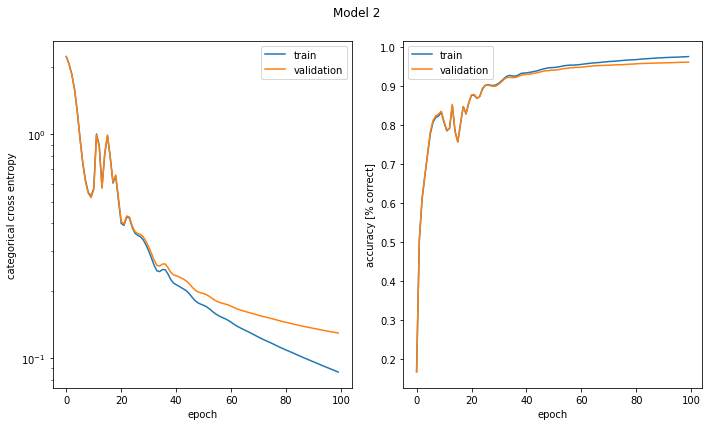

In [52]:
plot_v2(train2, title="Model 2")

In [48]:
test2

(tensor(0.9632), 0.117069311439991, tensor([ 7,  2,  1,  ...,  4,  5,  6]))

In [ ]:
model3, train3 = default_net_3(train_input, train_target, num_of_neurons=(784, 500, 200, 100, 10), activation='relu', lr=0.1, momentum_coef=0.9, weight_decay=0.2, p_dropout=0.0, num_of_epochs=100, val_split=0.5, verbose=0)
test3 = model3.evaluate(test_input, test_target, return_pred=True)

In [ ]:
plot_v2(train3, title="Model 3")

In [ ]:
test3

In [58]:
model4, train4 = default_net_4(train_input, train_target, num_of_neurons=(784, 500, 200, 100, 10), activation='relu', lr=0.1, momentum_coef=0.9, weight_decay=0.2, p_dropout=0.0, num_of_epochs=100, val_split=0.5, verbose=0)
test4 = model4.evaluate(test_input, test_target, return_pred=True)

Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Dropout 
Added Module Name: 3_Linear 
Added Module Name: 4_ReLU 
Added Module Name: 5_Dropout 
Added Module Name: 6_Linear 
Added Module Name: 7_ReLU 
Added Module Name: 8_Dropout 
Added Module Name: 9_Linear 
Added Module Name: 10_ReLU 
x_train.shape: torch.Size([30000, 784]) -- y_train.shape: torch.Size([30000, 10])
x_val.shape: torch.Size([30000, 784]) -- y_val.shape: torch.Size([30000, 10])


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

key: train_loss -- value: 0.9169866442680359
key: train_acc -- value: 0.2107333391904831
key: val_loss -- value: 0.9184646606445312
key: val_acc -- value: 0.20649999380111694


  1%|▊                                                                                 | 1/100 [00:02<04:51,  2.94s/it]

key: train_loss -- value: 0.8897601962089539
key: train_acc -- value: 0.28726667165756226
key: val_loss -- value: 0.8904201984405518
key: val_acc -- value: 0.28566667437553406


  2%|█▋                                                                                | 2/100 [00:06<05:08,  3.15s/it]

key: train_loss -- value: 0.8358072638511658
key: train_acc -- value: 0.3686999976634979
key: val_loss -- value: 0.8373507261276245
key: val_acc -- value: 0.3644999861717224


  3%|██▍                                                                               | 3/100 [00:09<05:00,  3.09s/it]

key: train_loss -- value: 0.7919632792472839
key: train_acc -- value: 0.32473334670066833
key: val_loss -- value: 0.7951929569244385
key: val_acc -- value: 0.32249999046325684


  4%|███▎                                                                              | 4/100 [00:11<04:47,  3.00s/it]

key: train_loss -- value: 0.7568734884262085
key: train_acc -- value: 0.41696667671203613
key: val_loss -- value: 0.7603850364685059
key: val_acc -- value: 0.4127666652202606


  5%|████                                                                              | 5/100 [00:14<04:39,  2.94s/it]

key: train_loss -- value: 0.712038516998291
key: train_acc -- value: 0.4702666699886322
key: val_loss -- value: 0.7149544358253479
key: val_acc -- value: 0.46426665782928467


  6%|████▉                                                                             | 6/100 [00:17<04:33,  2.91s/it]

key: train_loss -- value: 0.688491702079773
key: train_acc -- value: 0.4592333436012268
key: val_loss -- value: 0.6913856863975525
key: val_acc -- value: 0.4546999931335449


  7%|█████▋                                                                            | 7/100 [00:20<04:29,  2.90s/it]

key: train_loss -- value: 0.6522201299667358
key: train_acc -- value: 0.5124666690826416
key: val_loss -- value: 0.6556215882301331
key: val_acc -- value: 0.5095000267028809


  8%|██████▌                                                                           | 8/100 [00:22<04:24,  2.87s/it]

key: train_loss -- value: 0.6154103875160217
key: train_acc -- value: 0.5669666528701782
key: val_loss -- value: 0.6188295483589172
key: val_acc -- value: 0.5625333189964294


  9%|███████▍                                                                          | 9/100 [00:25<04:19,  2.85s/it]

key: train_loss -- value: 0.5783374309539795
key: train_acc -- value: 0.5895000100135803
key: val_loss -- value: 0.581625759601593
key: val_acc -- value: 0.5860999822616577


 10%|████████                                                                         | 10/100 [00:28<04:16,  2.85s/it]

key: train_loss -- value: 0.5554010272026062
key: train_acc -- value: 0.6015666723251343
key: val_loss -- value: 0.5582982301712036
key: val_acc -- value: 0.5999333262443542


 11%|████████▉                                                                        | 11/100 [00:31<04:11,  2.83s/it]

key: train_loss -- value: 0.5360352993011475
key: train_acc -- value: 0.6136333346366882
key: val_loss -- value: 0.538908064365387
key: val_acc -- value: 0.6121666431427002


 12%|█████████▋                                                                       | 12/100 [00:33<04:08,  2.82s/it]

key: train_loss -- value: 0.5273652076721191
key: train_acc -- value: 0.6347333192825317
key: val_loss -- value: 0.5313496589660645
key: val_acc -- value: 0.6281333565711975


 13%|██████████▌                                                                      | 13/100 [00:36<04:04,  2.81s/it]

key: train_loss -- value: 0.515566349029541
key: train_acc -- value: 0.6268333196640015
key: val_loss -- value: 0.5192739367485046
key: val_acc -- value: 0.6223000288009644


 14%|███████████▎                                                                     | 14/100 [00:39<04:00,  2.80s/it]

key: train_loss -- value: 0.5110431909561157
key: train_acc -- value: 0.6528333425521851
key: val_loss -- value: 0.5146853923797607
key: val_acc -- value: 0.6480000019073486


 15%|████████████▏                                                                    | 15/100 [00:42<03:59,  2.82s/it]

key: train_loss -- value: 0.4869355261325836
key: train_acc -- value: 0.669700026512146
key: val_loss -- value: 0.49242621660232544
key: val_acc -- value: 0.6642666459083557


 16%|████████████▉                                                                    | 16/100 [00:45<03:58,  2.84s/it]

key: train_loss -- value: 0.4748590588569641
key: train_acc -- value: 0.6903333067893982
key: val_loss -- value: 0.48052719235420227
key: val_acc -- value: 0.6844666600227356


 17%|█████████████▊                                                                   | 17/100 [00:48<03:56,  2.85s/it]

key: train_loss -- value: 0.4991564154624939
key: train_acc -- value: 0.6557000279426575
key: val_loss -- value: 0.5028627514839172
key: val_acc -- value: 0.6527000069618225


 18%|██████████████▌                                                                  | 18/100 [00:51<03:55,  2.87s/it]

key: train_loss -- value: 0.46555066108703613
key: train_acc -- value: 0.6797000169754028
key: val_loss -- value: 0.47070029377937317
key: val_acc -- value: 0.6741999983787537


 19%|███████████████▍                                                                 | 19/100 [00:54<03:52,  2.87s/it]

key: train_loss -- value: 0.46926143765449524
key: train_acc -- value: 0.6756666898727417
key: val_loss -- value: 0.4753201901912689
key: val_acc -- value: 0.6693000197410583


 20%|████████████████▏                                                                | 20/100 [00:57<03:50,  2.88s/it]

key: train_loss -- value: 0.4712070822715759
key: train_acc -- value: 0.67330002784729
key: val_loss -- value: 0.47616758942604065
key: val_acc -- value: 0.6690666675567627


 21%|█████████████████                                                                | 21/100 [01:00<03:47,  2.89s/it]

key: train_loss -- value: 0.45899784564971924
key: train_acc -- value: 0.6780333518981934
key: val_loss -- value: 0.4638596773147583
key: val_acc -- value: 0.6732666492462158


 22%|█████████████████▊                                                               | 22/100 [01:03<03:45,  2.89s/it]

key: train_loss -- value: 0.4672074019908905
key: train_acc -- value: 0.6722666621208191
key: val_loss -- value: 0.4736577272415161
key: val_acc -- value: 0.6652666926383972


 23%|██████████████████▋                                                              | 23/100 [01:06<03:42,  2.89s/it]

key: train_loss -- value: 0.45944786071777344
key: train_acc -- value: 0.6755666732788086
key: val_loss -- value: 0.4660751223564148
key: val_acc -- value: 0.6694999933242798


 24%|███████████████████▍                                                             | 24/100 [01:09<03:39,  2.89s/it]

key: train_loss -- value: 0.4514976143836975
key: train_acc -- value: 0.6853333115577698
key: val_loss -- value: 0.4575394093990326
key: val_acc -- value: 0.6797000169754028


 25%|████████████████████▎                                                            | 25/100 [01:12<03:36,  2.89s/it]

key: train_loss -- value: 0.4519208073616028
key: train_acc -- value: 0.6865333318710327
key: val_loss -- value: 0.4581003487110138
key: val_acc -- value: 0.6800666451454163


 26%|█████████████████████                                                            | 26/100 [01:15<03:34,  2.89s/it]

key: train_loss -- value: 0.4383235573768616
key: train_acc -- value: 0.6905999779701233
key: val_loss -- value: 0.445130854845047
key: val_acc -- value: 0.6829666495323181


 27%|█████████████████████▊                                                           | 27/100 [01:18<03:31,  2.90s/it]

key: train_loss -- value: 0.44029271602630615
key: train_acc -- value: 0.6888666749000549
key: val_loss -- value: 0.44731128215789795
key: val_acc -- value: 0.6830999851226807


 28%|██████████████████████▋                                                          | 28/100 [01:21<03:29,  2.91s/it]

key: train_loss -- value: 0.43188124895095825
key: train_acc -- value: 0.7009666562080383
key: val_loss -- value: 0.4385172724723816
key: val_acc -- value: 0.6945000290870667


 29%|███████████████████████▍                                                         | 29/100 [01:24<03:26,  2.91s/it]

key: train_loss -- value: 0.43230608105659485
key: train_acc -- value: 0.7060666680335999
key: val_loss -- value: 0.43899020552635193
key: val_acc -- value: 0.6985666751861572


 30%|████████████████████████▎                                                        | 30/100 [01:27<03:23,  2.91s/it]

key: train_loss -- value: 0.42511823773384094
key: train_acc -- value: 0.7100333571434021
key: val_loss -- value: 0.43213793635368347
key: val_acc -- value: 0.7027333378791809


 31%|█████████████████████████                                                        | 31/100 [01:30<03:20,  2.91s/it]

key: train_loss -- value: 0.4248417615890503
key: train_acc -- value: 0.7063666582107544
key: val_loss -- value: 0.4318693280220032
key: val_acc -- value: 0.6985999941825867


 32%|█████████████████████████▉                                                       | 32/100 [01:33<03:17,  2.91s/it]

key: train_loss -- value: 0.4197193384170532
key: train_acc -- value: 0.7102333307266235
key: val_loss -- value: 0.4267737865447998
key: val_acc -- value: 0.703499972820282


 33%|██████████████████████████▋                                                      | 33/100 [01:36<03:15,  2.91s/it]

key: train_loss -- value: 0.4181193709373474
key: train_acc -- value: 0.71506667137146
key: val_loss -- value: 0.4254811406135559
key: val_acc -- value: 0.7078333497047424


 34%|███████████████████████████▌                                                     | 34/100 [01:39<03:12,  2.92s/it]

key: train_loss -- value: 0.415103018283844
key: train_acc -- value: 0.7192000150680542
key: val_loss -- value: 0.4227277636528015
key: val_acc -- value: 0.7107999920845032


 35%|████████████████████████████▎                                                    | 35/100 [01:42<03:09,  2.92s/it]

key: train_loss -- value: 0.411936491727829
key: train_acc -- value: 0.7174000144004822
key: val_loss -- value: 0.4195380210876465
key: val_acc -- value: 0.7107999920845032


 36%|█████████████████████████████▏                                                   | 36/100 [01:45<03:06,  2.92s/it]

key: train_loss -- value: 0.41072046756744385
key: train_acc -- value: 0.7153000235557556
key: val_loss -- value: 0.41826871037483215
key: val_acc -- value: 0.7079333066940308


 37%|█████████████████████████████▉                                                   | 37/100 [01:48<03:04,  2.92s/it]

key: train_loss -- value: 0.406840980052948
key: train_acc -- value: 0.7178333401679993
key: val_loss -- value: 0.41464143991470337
key: val_acc -- value: 0.7101333141326904


 38%|██████████████████████████████▊                                                  | 38/100 [01:51<03:01,  2.92s/it]

key: train_loss -- value: 0.40594011545181274
key: train_acc -- value: 0.720633327960968
key: val_loss -- value: 0.4140374958515167
key: val_acc -- value: 0.7131666541099548


 39%|███████████████████████████████▌                                                 | 39/100 [01:53<02:58,  2.92s/it]

key: train_loss -- value: 0.4028891623020172
key: train_acc -- value: 0.7224666476249695
key: val_loss -- value: 0.4111001193523407
key: val_acc -- value: 0.7139333486557007


 40%|████████████████████████████████▍                                                | 40/100 [01:56<02:55,  2.92s/it]

key: train_loss -- value: 0.40159958600997925
key: train_acc -- value: 0.7193999886512756
key: val_loss -- value: 0.4097661077976227
key: val_acc -- value: 0.7113999724388123


 41%|█████████████████████████████████▏                                               | 41/100 [02:00<02:52,  2.93s/it]

key: train_loss -- value: 0.3992234468460083
key: train_acc -- value: 0.7193666696548462
key: val_loss -- value: 0.4074667692184448
key: val_acc -- value: 0.7116333246231079


 42%|██████████████████████████████████                                               | 42/100 [02:03<02:50,  2.94s/it]

key: train_loss -- value: 0.3977815508842468
key: train_acc -- value: 0.7215333580970764
key: val_loss -- value: 0.4061671197414398
key: val_acc -- value: 0.713533341884613


 43%|██████████████████████████████████▊                                              | 43/100 [02:06<02:47,  2.95s/it]

key: train_loss -- value: 0.3955840468406677
key: train_acc -- value: 0.7236999869346619
key: val_loss -- value: 0.4041343629360199
key: val_acc -- value: 0.7157666683197021


 44%|███████████████████████████████████▋                                             | 44/100 [02:09<02:45,  2.95s/it]

key: train_loss -- value: 0.3941977918148041
key: train_acc -- value: 0.724133312702179
key: val_loss -- value: 0.4029400646686554
key: val_acc -- value: 0.7159666419029236


 45%|████████████████████████████████████▍                                            | 45/100 [02:13<02:42,  2.96s/it]

key: train_loss -- value: 0.392381489276886
key: train_acc -- value: 0.7247999906539917
key: val_loss -- value: 0.40121692419052124
key: val_acc -- value: 0.7164333462715149


 46%|█████████████████████████████████████▎                                           | 46/100 [02:16<02:39,  2.96s/it]

key: train_loss -- value: 0.3908149302005768
key: train_acc -- value: 0.7262333035469055
key: val_loss -- value: 0.39963382482528687
key: val_acc -- value: 0.7175333499908447


 47%|██████████████████████████████████████                                           | 47/100 [02:20<02:38,  2.98s/it]

key: train_loss -- value: 0.38953346014022827
key: train_acc -- value: 0.7278333306312561
key: val_loss -- value: 0.39836516976356506
key: val_acc -- value: 0.7194666862487793


 48%|██████████████████████████████████████▉                                          | 48/100 [02:23<02:34,  2.98s/it]

key: train_loss -- value: 0.387805312871933
key: train_acc -- value: 0.7295666933059692
key: val_loss -- value: 0.39687201380729675
key: val_acc -- value: 0.7212666869163513


 49%|███████████████████████████████████████▋                                         | 49/100 [02:26<02:32,  2.99s/it]

key: train_loss -- value: 0.386702299118042
key: train_acc -- value: 0.7311999797821045
key: val_loss -- value: 0.39606690406799316
key: val_acc -- value: 0.7228333353996277


 50%|████████████████████████████████████████▌                                        | 50/100 [02:29<02:29,  3.00s/it]

key: train_loss -- value: 0.38515505194664
key: train_acc -- value: 0.7321666479110718
key: val_loss -- value: 0.3945915400981903
key: val_acc -- value: 0.7235666513442993


 51%|█████████████████████████████████████████▎                                       | 51/100 [02:32<02:26,  3.00s/it]

key: train_loss -- value: 0.3838981091976166
key: train_acc -- value: 0.7321333289146423
key: val_loss -- value: 0.3932591378688812
key: val_acc -- value: 0.7245333194732666


 52%|██████████████████████████████████████████                                       | 52/100 [02:35<02:23,  3.00s/it]

key: train_loss -- value: 0.3827594816684723
key: train_acc -- value: 0.7329000234603882
key: val_loss -- value: 0.39220744371414185
key: val_acc -- value: 0.7250666618347168


 53%|██████████████████████████████████████████▉                                      | 53/100 [02:38<02:20,  3.00s/it]

key: train_loss -- value: 0.38138696551322937
key: train_acc -- value: 0.7347666621208191
key: val_loss -- value: 0.39120274782180786
key: val_acc -- value: 0.7261666655540466


 54%|███████████████████████████████████████████▋                                     | 54/100 [02:41<02:17,  2.99s/it]

key: train_loss -- value: 0.3805139660835266
key: train_acc -- value: 0.73580002784729
key: val_loss -- value: 0.39057835936546326
key: val_acc -- value: 0.7273666858673096


 55%|████████████████████████████████████████████▌                                    | 55/100 [02:44<02:14,  2.99s/it]

key: train_loss -- value: 0.3791990280151367
key: train_acc -- value: 0.7358333468437195
key: val_loss -- value: 0.3892041742801666
key: val_acc -- value: 0.7275333404541016


 56%|█████████████████████████████████████████████▎                                   | 56/100 [02:47<02:11,  2.99s/it]

key: train_loss -- value: 0.37832802534103394
key: train_acc -- value: 0.735966682434082
key: val_loss -- value: 0.388318806886673
key: val_acc -- value: 0.727233350276947


 57%|██████████████████████████████████████████████▏                                  | 57/100 [02:50<02:08,  2.99s/it]

key: train_loss -- value: 0.37714001536369324
key: train_acc -- value: 0.7372999787330627
key: val_loss -- value: 0.387410968542099
key: val_acc -- value: 0.728766679763794


 58%|██████████████████████████████████████████████▉                                  | 58/100 [02:53<02:05,  2.99s/it]

key: train_loss -- value: 0.3761928975582123
key: train_acc -- value: 0.739300012588501
key: val_loss -- value: 0.3867532014846802
key: val_acc -- value: 0.7297000288963318


 59%|███████████████████████████████████████████████▊                                 | 59/100 [02:56<02:02,  2.99s/it]

key: train_loss -- value: 0.3751438558101654
key: train_acc -- value: 0.7399666905403137
key: val_loss -- value: 0.38573548197746277
key: val_acc -- value: 0.7304666638374329


 60%|████████████████████████████████████████████████▌                                | 60/100 [02:59<01:59,  2.99s/it]

key: train_loss -- value: 0.3742101490497589
key: train_acc -- value: 0.7402999997138977
key: val_loss -- value: 0.38475289940834045
key: val_acc -- value: 0.7310333251953125


 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:02<01:56,  2.99s/it]

key: train_loss -- value: 0.37327903509140015
key: train_acc -- value: 0.7419999837875366
key: val_loss -- value: 0.3839717209339142
key: val_acc -- value: 0.7320666909217834


 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:05<01:53,  2.99s/it]

key: train_loss -- value: 0.3724014461040497
key: train_acc -- value: 0.7432000041007996
key: val_loss -- value: 0.38333532214164734
key: val_acc -- value: 0.7330999970436096


 63%|███████████████████████████████████████████████████                              | 63/100 [03:08<01:50,  3.00s/it]

key: train_loss -- value: 0.37155580520629883
key: train_acc -- value: 0.7440000176429749
key: val_loss -- value: 0.3826049268245697
key: val_acc -- value: 0.7336999773979187


 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:11<01:47,  3.00s/it]

key: train_loss -- value: 0.37068599462509155
key: train_acc -- value: 0.7445999979972839
key: val_loss -- value: 0.38175278902053833
key: val_acc -- value: 0.7340666651725769


 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:15<01:45,  3.01s/it]

key: train_loss -- value: 0.3698970675468445
key: train_acc -- value: 0.7452333569526672
key: val_loss -- value: 0.38107749819755554
key: val_acc -- value: 0.7350000143051147


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:19<01:42,  3.02s/it]

key: train_loss -- value: 0.369037389755249
key: train_acc -- value: 0.7461666464805603
key: val_loss -- value: 0.38043731451034546
key: val_acc -- value: 0.7357000112533569


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [03:23<01:40,  3.03s/it]

key: train_loss -- value: 0.3682956397533417
key: train_acc -- value: 0.7462999820709229
key: val_loss -- value: 0.3798726201057434
key: val_acc -- value: 0.7356666922569275


 68%|███████████████████████████████████████████████████████                          | 68/100 [03:26<01:37,  3.03s/it]

key: train_loss -- value: 0.3674947917461395
key: train_acc -- value: 0.7470333576202393
key: val_loss -- value: 0.3791627883911133
key: val_acc -- value: 0.7362666726112366


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [03:29<01:34,  3.04s/it]

key: train_loss -- value: 0.36676621437072754
key: train_acc -- value: 0.7475666403770447
key: val_loss -- value: 0.3785262703895569
key: val_acc -- value: 0.7366333603858948


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [03:33<01:31,  3.05s/it]

key: train_loss -- value: 0.3660491406917572
key: train_acc -- value: 0.7480000257492065
key: val_loss -- value: 0.37796157598495483
key: val_acc -- value: 0.7371666431427002


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [03:36<01:28,  3.05s/it]

key: train_loss -- value: 0.36532512307167053
key: train_acc -- value: 0.7482666373252869
key: val_loss -- value: 0.37739914655685425
key: val_acc -- value: 0.7375666499137878


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [03:39<01:25,  3.04s/it]

key: train_loss -- value: 0.36468032002449036
key: train_acc -- value: 0.7487333416938782
key: val_loss -- value: 0.3768775761127472
key: val_acc -- value: 0.7378333210945129


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [03:42<01:22,  3.05s/it]

key: train_loss -- value: 0.36397331953048706
key: train_acc -- value: 0.7495999932289124
key: val_loss -- value: 0.37625715136528015
key: val_acc -- value: 0.7383999824523926


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [03:46<01:19,  3.06s/it]

key: train_loss -- value: 0.36335888504981995
key: train_acc -- value: 0.750166654586792
key: val_loss -- value: 0.37573328614234924
key: val_acc -- value: 0.7389666438102722


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [03:49<01:16,  3.06s/it]

key: train_loss -- value: 0.3626895546913147
key: train_acc -- value: 0.7505999803543091
key: val_loss -- value: 0.3752034306526184
key: val_acc -- value: 0.739300012588501


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [03:52<01:13,  3.06s/it]

key: train_loss -- value: 0.3620869219303131
key: train_acc -- value: 0.7509999871253967
key: val_loss -- value: 0.3747543394565582
key: val_acc -- value: 0.7395666837692261


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [03:55<01:10,  3.06s/it]

key: train_loss -- value: 0.36146336793899536
key: train_acc -- value: 0.7518333196640015
key: val_loss -- value: 0.3742268681526184
key: val_acc -- value: 0.7398666739463806


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [03:58<01:07,  3.06s/it]

key: train_loss -- value: 0.3608747124671936
key: train_acc -- value: 0.752133309841156
key: val_loss -- value: 0.3736930191516876
key: val_acc -- value: 0.7402666807174683


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [04:01<01:04,  3.06s/it]

key: train_loss -- value: 0.3602876663208008
key: train_acc -- value: 0.7526666522026062
key: val_loss -- value: 0.3732219338417053
key: val_acc -- value: 0.7406666874885559


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [04:05<01:01,  3.06s/it]

key: train_loss -- value: 0.35971981287002563
key: train_acc -- value: 0.7532333135604858
key: val_loss -- value: 0.37282633781433105
key: val_acc -- value: 0.741266667842865


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [04:08<00:58,  3.07s/it]

key: train_loss -- value: 0.35916534066200256
key: train_acc -- value: 0.7540000081062317
key: val_loss -- value: 0.3723830282688141
key: val_acc -- value: 0.7416666746139526


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [04:11<00:55,  3.07s/it]

key: train_loss -- value: 0.3586110770702362
key: train_acc -- value: 0.7541999816894531
key: val_loss -- value: 0.37187132239341736
key: val_acc -- value: 0.7421666383743286


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [04:14<00:52,  3.07s/it]

key: train_loss -- value: 0.35808148980140686
key: train_acc -- value: 0.7544666528701782
key: val_loss -- value: 0.3714308738708496
key: val_acc -- value: 0.7423999905586243


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [04:17<00:49,  3.07s/it]

key: train_loss -- value: 0.3575453758239746
key: train_acc -- value: 0.755133330821991
key: val_loss -- value: 0.3710545301437378
key: val_acc -- value: 0.7427666783332825


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [04:21<00:46,  3.07s/it]

key: train_loss -- value: 0.3570382595062256
key: train_acc -- value: 0.7555000185966492
key: val_loss -- value: 0.3706730902194977
key: val_acc -- value: 0.7429666519165039


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [04:24<00:43,  3.08s/it]

key: train_loss -- value: 0.3565198481082916
key: train_acc -- value: 0.755466639995575
key: val_loss -- value: 0.3702116310596466
key: val_acc -- value: 0.7430999875068665


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [04:27<00:40,  3.08s/it]

key: train_loss -- value: 0.3560287654399872
key: train_acc -- value: 0.7559333443641663
key: val_loss -- value: 0.36980974674224854
key: val_acc -- value: 0.7437000274658203


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [04:31<00:36,  3.08s/it]

key: train_loss -- value: 0.35553181171417236
key: train_acc -- value: 0.7564333081245422
key: val_loss -- value: 0.3694605231285095
key: val_acc -- value: 0.7440999746322632


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [04:34<00:33,  3.08s/it]

key: train_loss -- value: 0.355055570602417
key: train_acc -- value: 0.7567999958992004
key: val_loss -- value: 0.36911895871162415
key: val_acc -- value: 0.7443333268165588


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [04:37<00:30,  3.08s/it]

key: train_loss -- value: 0.35458052158355713
key: train_acc -- value: 0.7569666504859924
key: val_loss -- value: 0.3687369227409363
key: val_acc -- value: 0.7444000244140625


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [04:40<00:27,  3.08s/it]

key: train_loss -- value: 0.3541213870048523
key: train_acc -- value: 0.7574999928474426
key: val_loss -- value: 0.36837321519851685
key: val_acc -- value: 0.7447666525840759


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [04:43<00:24,  3.08s/it]

key: train_loss -- value: 0.353663831949234
key: train_acc -- value: 0.7577999830245972
key: val_loss -- value: 0.3680403530597687
key: val_acc -- value: 0.7452333569526672


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [04:45<00:21,  3.07s/it]

key: train_loss -- value: 0.3532186448574066
key: train_acc -- value: 0.7580999732017517
key: val_loss -- value: 0.3677126169204712
key: val_acc -- value: 0.745199978351593


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [04:49<00:18,  3.07s/it]

key: train_loss -- value: 0.35277819633483887
key: train_acc -- value: 0.7583333253860474
key: val_loss -- value: 0.3673900365829468
key: val_acc -- value: 0.7454333305358887


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [04:52<00:15,  3.08s/it]

key: train_loss -- value: 0.3523499369621277
key: train_acc -- value: 0.7584333419799805
key: val_loss -- value: 0.36706769466400146
key: val_acc -- value: 0.7460333108901978


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [04:55<00:12,  3.08s/it]

key: train_loss -- value: 0.35192105174064636
key: train_acc -- value: 0.7588333487510681
key: val_loss -- value: 0.36674097180366516
key: val_acc -- value: 0.7463333606719971


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [04:58<00:09,  3.08s/it]

key: train_loss -- value: 0.3515070974826813
key: train_acc -- value: 0.7590333223342896
key: val_loss -- value: 0.3664349913597107
key: val_acc -- value: 0.7464333176612854


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [05:01<00:06,  3.08s/it]

key: train_loss -- value: 0.3510928153991699
key: train_acc -- value: 0.7592666745185852
key: val_loss -- value: 0.3661397099494934
key: val_acc -- value: 0.7467333078384399


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [05:04<00:03,  3.08s/it]

key: train_loss -- value: 0.35069021582603455
key: train_acc -- value: 0.7596333622932434
key: val_loss -- value: 0.3658483624458313
key: val_acc -- value: 0.746999979019165


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:07<00:00,  3.08s/it]
